In [188]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Account
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

In [189]:
parser = argparse.ArgumentParser()

parser.add_argument('--buy_ub', type = float, default = 0.1)
parser.add_argument('--sell_ub', type = float, default = 0.1)
parser.add_argument('--path', type = str, default = 'input\sh.csv')
parser.add_argument('--label', type = str, default = 'Price')

parser.add_argument('--test_size', type = float, default = 0.01)
parser.add_argument('--seq_size', type = float, default = 20)


parser.add_argument('--input_size', type = int, default = 4)

args = parser.parse_args(args=[])

In [190]:
df_main = pd.read_csv(args.path).drop(columns='Unnamed: 0')
scaler = MinMaxScaler(feature_range=(-1, 1))
for col in df_main.columns:
    df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))
df_main['target'] = df_main[args.label].shift(-1)
df_main

,code,open,close,low,vol,amount,p_change,Date,Price,target
0,-1.0,-0.237249,-0.206036,-0.208219,-0.807661,-0.769251,0.236740,-1.000000,-0.234683,-0.228755
1,-1.0,-0.230217,-0.218029,-0.184855,-0.829741,-0.784885,0.050453,-1.000000,-0.228755,-0.244636
2,-1.0,-0.238306,-0.255801,-0.232324,-0.824092,-0.786198,-0.124191,-0.999483,-0.244636,-0.284760
3,-1.0,-0.283202,-0.251140,-0.246324,-0.882959,-0.851361,0.164295,-0.998966,-0.284760,-0.225764
4,-1.0,-0.212305,-0.250108,-0.225585,-0.795109,-0.756730,0.139715,-0.997415,-0.225764,-0.256781
...,...,...,...,...,...,...,...,...,...,...
2831,-1.0,0.463917,0.459190,0.490422,-0.471163,-0.250699,-0.122898,0.997415,0.455049,0.439976
2832,-1.0,0.413305,0.472859,0.487678,-0.514222,-0.251919,0.200517,0.997932,0.439976,0.432468
2833,-1.0,0.440404,0.465457,0.484246,-0.404896,-0.017596,0.094437,0.999483,0.432468,0.418093
2834,-1.0,0.417532,0.461340,0.459303,-0.358299,-0.052879,0.111255,1.000000,0.418093,0.462499


In [191]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

        self.fc_h = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out)
        return out

def create_seq_data(data_raw, seq, arg):
    data_feat, data_target = [],[]
    for index in range(len(data_raw) - seq):
        data_feat.append(data_raw[[args.label] * arg.input_size][index: index + seq].values)
        data_target.append(data_raw['target'][index:index + seq])
    data_feat = np.array(data_feat)
    data_target = np.array(data_target)
    return data_feat, data_target

def transform_data(data_feat, data_target, seq, input_dim = 4):
    trainX = torch.from_numpy(data_feat.reshape(-1, seq, input_dim)).type(torch.Tensor)
    trainY = torch.from_numpy(data_target.reshape(-1, seq, 1)).type(torch.Tensor)
    return trainX, trainY

In [192]:
feat, target = create_seq_data(df_main, args.seq_size, args)
X, y = transform_data(feat, target, args.seq_size, args.input_size)

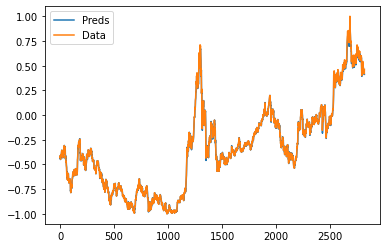

In [193]:
model = torch.load('model/rnn.pkl')
pred = model(X)
pred = pred.detach().numpy()[:,-1,0]
y = y.detach().numpy()[:,-1,0]
plt.plot(pred, label="Preds")
plt.plot(y, label="Data")
plt.legend()
plt.show()

In [194]:
y = scaler.inverse_transform(y.reshape(-1,1))
pred = scaler.inverse_transform(pred.reshape(-1,1))

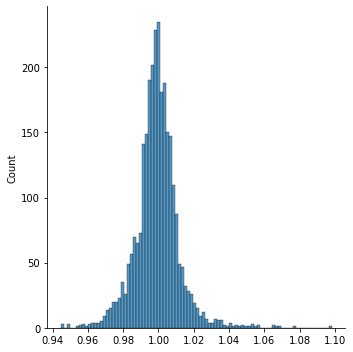

In [195]:
result = []
for i in range(len(pred)):
    result.append(pred[i][0] / y[i][0])
import seaborn as sns
sns.displot(result)

plt.show()

In [196]:
price_dic = {i: (y[i][0], None) for i in range(len(y))}

100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


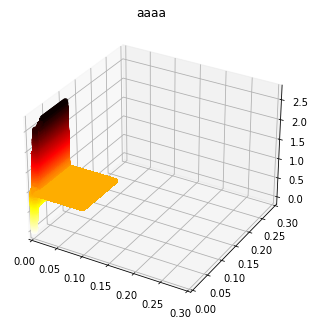

In [197]:
x_result = []
y_result = []
z_result = []

for i in tqdm(np.linspace(0, args.buy_ub, 50)):
    for j in np.linspace(0, args.sell_ub, 50):
        account  = Account(price_dic, price_dic)
        for day in range(len(pred) - 1):
            account.setDay(day)
            if pred[day+1][0] > y[day][0] * (i + 1):
                account.buyBit(1000000000)
            elif pred[day+1][0] < y[day][0] * (1 - j):
                account.sellBit(1000000000)
            x_result.append(i)
            y_result.append(j)
            z_result.append(account.getState()['Total'])
        
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_result, y_result, z_result, c = z_result, alpha = 0.8, cmap=plt.cm.hot_r)
ax.set_xlim(0, args.buy_ub)
ax.set_ylim(0, args.sell_ub)
plt.title('aaaa')
plt.show()

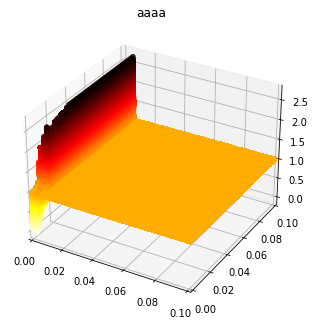

In [199]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_result, y_result, z_result, c = z_result, alpha = 0.8, cmap=plt.cm.hot_r)
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.1)
plt.title('aaaa')
plt.show()

In [198]:
i = np.argmax(np.array(z_result))
print(x_result[i], y_result[i])

0.006122448979591837 0.030612244897959186
